# ASTRO 530 Homework 4 - Olivier Gilbert - Oct 29 2025

## 1.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as cst
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
plt.rc("axes", labelsize=16) 
T_eff = 5800*u.K # K
R_star = 1*cst.R_sun

wav = np.logspace(np.log10(0.05),np.log10(1000),100)*u.um

### a)

We start with a simple 2-component disk model

---Disk model---
	Component 0 : Disk(T=300.0 K, r=[0.1 AU,5.0 AU])
	Component 1 : Disk(T=50.0 K, r=[5.0 AU,100.0 AU])
----------------



/opt/anaconda3/envs/astro532/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/929880131.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*disk.L_lambda(wav)).value), ls="--", lw=2, label=f"Component {i}")
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/929880131.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label, **kwargs)


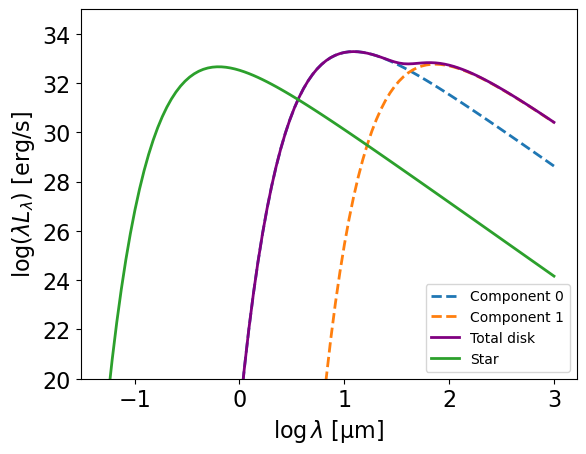

In [122]:
from scipy.integrate import quad
def planck(wav, T):
    if T == 0: return 0
    return 2*cst.h*cst.c**2*wav**(-5) / (np.exp(cst.h*cst.c/(wav*cst.k_B*T))-1)

def L_lamb_star(wav):
    return (planck(wav, T_eff) * (2*np.pi*R_star**2)).to(u.erg / u.s / u.um)

class MultiDisk:
    def __init__(self, disks):
        self.disks = disks
    def L_lambda(self, wav):
        L_lam = 0
        for i in range(len(self.disks)):
            L_lam += self.disks[i].L_lambda(wav)
        return L_lam
    def __str__(self):
        s = f"---Disk model---\n"
        for i, disk in enumerate(self.disks):
            s += f"\tComponent {i} : {disk.__str__()}\n"
        s += f"----------------\n"
        return s
    def __add__(self, disk2):
        if type(disk2) == MultiDisk:
            return MultiDisk(self.disks + disk2.disks)
        if type(disk2) != list:
            disk2 = [disk2]
        return MultiDisk(self.disks + disk2)
    def plot(self, plot_comps=True, main_col="purple", label="Total disk", **kwargs):
        if plot_comps:
            for i, disk in enumerate(self.disks):
                plt.plot(np.log10(wav.value), np.log10((wav*disk.L_lambda(wav)).value), ls="--", lw=2, label=f"Component {i}")
        plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label, **kwargs)

class Disk(MultiDisk):
    def __init__(self, spatial_extent, Temp):
        self.ri = spatial_extent[0]
        self.rf = spatial_extent[1]
        self.T = Temp
    def __str__(self):
        return f"Disk(T={self.T}, r=[{self.ri},{self.rf}])"
    def temp(self, r): # abstract method for temp
        return (self.T if r <= self.rf and r >= self.ri else 0)
    def L_lambda(self, wav):
        return (planck(wav, self.T) * (np.pi*(self.rf**2-self.ri**2))).to(u.erg / u.s / u.um)
    def __add__(self, disk2):
        return MultiDisk([self, disk2])

disk1 = Disk((0.1*u.AU,5*u.AU),300*u.K)
disk2 = Disk((5*u.AU,100*u.AU),50*u.K)
model1 = disk1+disk2
print(model1)
model1.plot()
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()
plt.show()

### b)

Now, we can make another class with a more complex disk model:

#### i)

/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/4135054919.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)


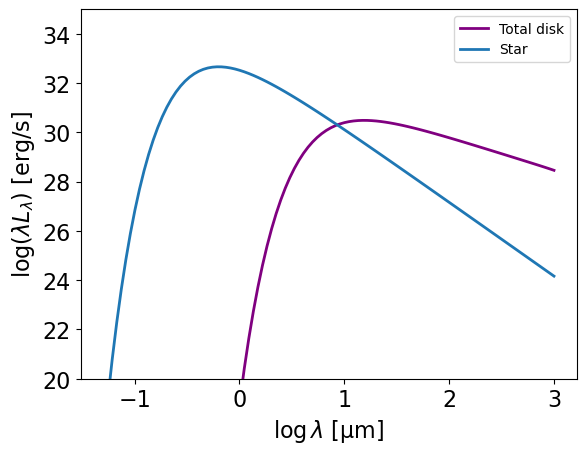

In [123]:
class ComplexDisk(MultiDisk):
    def __init__(self, spatial_extent):
        self.ri = spatial_extent[0]
        self.rf = spatial_extent[1]
    def __str__(self):
        return f"ComplexDisk(r=[{self.ri},{self.rf}])"
    def temp(self, r): # abstract method for temp
        T_ef = T_eff.to(u.K).value
        R_s = R_star.to(u.AU).value
        T_disk = T_ef*( 1/np.pi*(np.asin(R_s/r)-(R_s/r)*np.sqrt(1-(R_s/r)**2)) )**(1/4)
        return T_disk*u.K
    def L_lambda(self, wav):
        integrs = []
        for w in wav:
            func = lambda r: ((planck(w, self.temp(r))).to(u.erg/u.s/u.AU**3)).value*2*np.pi*r
            integrated = (quad(func, self.ri.to(u.AU).value, self.rf.to(u.AU).value)[0]) # erg/s/um
            integrs.append(integrated)
        return np.array(integrs)*(u.erg / u.s / u.AU).to(u.erg / u.s / u.um)
    def __add__(self, disk2):
        return MultiDisk([self, disk2])
    def plot(self, main_col="purple", label="Total disk"):
        plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)
    
modeli = ComplexDisk((0.1*u.AU,100*u.AU))
modeli.plot()
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()

#### ii)

/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/4135054919.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)


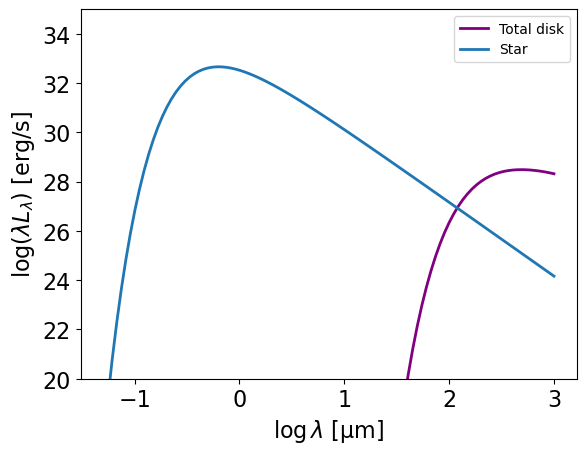

In [124]:
modelii = ComplexDisk((10*u.AU,100*u.AU))
modelii.plot()
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()

#### iii)

/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/1127370896.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*disk.L_lambda(wav)).value), ls="--", lw=2, label=f"Component {i}")
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/1127370896.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)


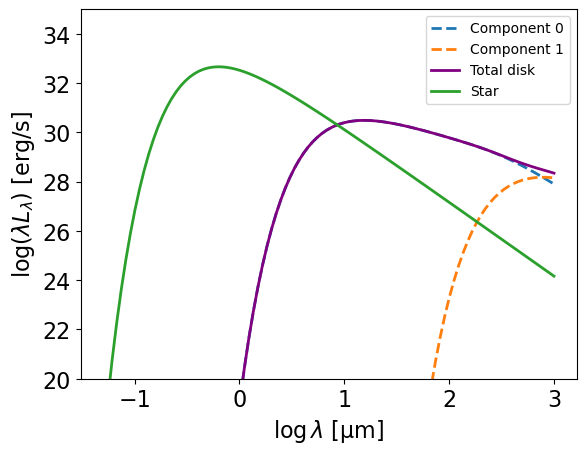

In [80]:
modeliii = ComplexDisk((0.1*u.AU,10*u.AU)) + ComplexDisk((20*u.AU,100*u.AU))
modeliii.plot()
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()

### c)

We first plot all three assumed structures from b):

/opt/anaconda3/envs/astro532/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/4135054919.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/1127370896.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)


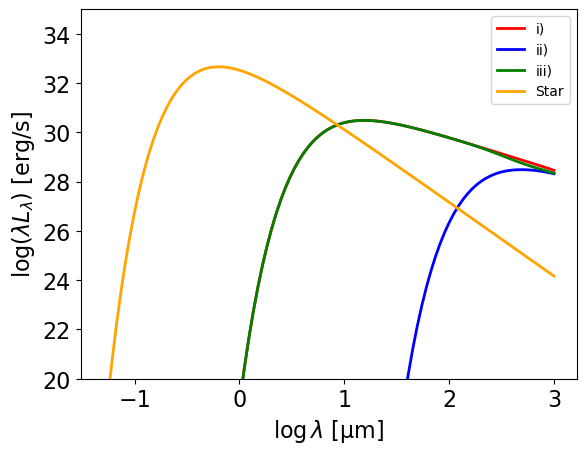

In [82]:
modeli.plot(main_col="red", label="i)")
modelii.plot(main_col="blue", label="ii)")
modeliii.plot(plot_comps=False, main_col="green", label="iii)")
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star", color="orange")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()
plt.show()

The structure that is the most similar to the 2-component disk model is ii). We thus try to guess temperatures to reproduce its SED:

/opt/anaconda3/envs/astro532/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/4135054919.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/929880131.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label, **kwargs)


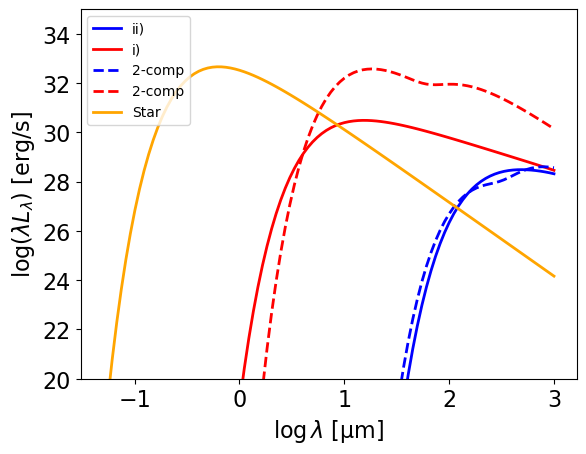

In [131]:
modelii.plot(main_col="blue", label="ii)")
modeli.plot(main_col="red", label="i)")
disk1 = Disk((0.1*u.AU,5*u.AU),13.5*u.K)
disk2 = Disk((5*u.AU,100*u.AU),4.5*u.K)
model1 = disk1+disk2
model1.plot(main_col="blue", label="2-comp", plot_comps=False, ls="--")
disk1 = Disk((0.1*u.AU,5*u.AU),200*u.K)
disk2 = Disk((5*u.AU,100*u.AU),30*u.K)
model2 = disk1+disk2
model2.plot(main_col="red", label="2-comp", plot_comps=False, ls="--")
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star", color="orange")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend(loc="upper left")
plt.show()

With temperatures of 13.5K and 4.5K, it's possible to approximate the model ii) with the simple 2-component disk model. It's much harder to approximate the models i) and iii) with the 2-component model (as shown in red), because, to match the shorter wavelength slope, we need to have a higher temperature than the flux at longer wavelengths permit. It is therefore only possible to approximate one side of the SED.

## 2.

### a)

The rate of change of the mass $m$ of a spherical grain of radius $a$ as a function of vertical height $z$ is
$$\frac{\mathrm{d}m}{\mathrm{d}z} = -\pi a^2 nm_g$$
because of hydrostatic equilibrium in the disk. The pressure and gravity are always balanced vertically, so the pressure will be higher close to the midplane, where the gravity is also higher.

The density of the dust will therefore be greater close to the midplane, and more dust will be sticking together. The cross-section is effectively $\pi a^2$, and the number density is $n$, so the number of interactions will be $\pi a^2 n$, and the change in mass will be $m_g$ when dust sticks together to form bigger and more massive dust. The derivative is therefore $\frac{\mathrm{d}m}{\mathrm{d}z} = -\pi a^2 nm_g$ when using $z$ in the convention where the settling direction is opposite of $\hat{z}$.

### b)

$$\frac{\mathrm{d}m}{\mathrm{d}z} = -\pi a^2 nm_g$$
and the mass of a dust grain is
$$m = \frac{4\pi a^3 \rho_d}{3}$$
where $\rho_d$ is the dust density, so we can isolate $a$ in that equation:

$$a = \left(\frac{3m}{4\pi \rho_d}\right)^{1/3}$$

We can then rewrite the first equation without a dependency on $a$:
$$\frac{\mathrm{d}m}{\mathrm{d}z} = -\pi \left(\frac{3m}{4\pi \rho_d}\right)^{2/3} nm_g$$

### c)

$$nm_g = \eta_{gd}^{-1}\left(\frac{\Sigma}{2H}\right)$$

where $\eta_{gd}^{-1}$ is the gas-to-dust ratio, $\Sigma$ is the surface density of the disk, and $H$ is the scale height.

We can simply inject this in the equation to solve:

\begin{align*}
    \frac{\mathrm{d}m}{\mathrm{d}z} &= -\pi \left(\frac{3m}{4\pi \rho_d}\right)^{2/3} nm_g \\
    \frac{\mathrm{d}m}{\mathrm{d}z} &= -\pi \left(\frac{3m}{4\pi \rho_d}\right)^{2/3} \eta_{gd}^{-1}\left(\frac{\Sigma}{2H}\right) \\
    m^{-2/3}\mathrm{d}m &= -\pi \left(\frac{3}{4\pi \rho_d}\right)^{2/3} \eta_{gd}^{-1}\left(\frac{\Sigma}{2H}\right)\mathrm{d}z \\
    \int_{m_g}^{m}m^{-2/3}\mathrm{d}m &= -\pi \left(\frac{3}{4\pi \rho_d}\right)^{2/3} \eta_{gd}^{-1}\left(\frac{\Sigma}{2H}\right)\int_{H}^0\mathrm{d}z \\
    \frac{m^{1/3}-m_g^{-1/3}}{1/3} &= -\pi \left(\frac{3}{4\pi \rho_d}\right)^{2/3} \eta_{gd}^{-1}\left(\frac{\Sigma}{2H}\right)(-H) \\
    3(m^{1/3}-m_g^{1/3}) &= \pi \left(\frac{3}{4\pi \rho_d}\right)^{2/3} \eta_{gd}^{-1}\left(\frac{\Sigma}{2}\right) \\
\end{align*}
We can assume the initial mass of the grain $m_g$ is negligible compared to its final mass $m$, so $m^{1/3}-m_g^{1/3}\approx m^{1/3}$:
$$3m^{1/3} \approx \pi \left(\frac{3}{4\pi \rho_d}\right)^{2/3} \eta_{gd}^{-1}\left(\frac{\Sigma}{2}\right)$$
$$m \approx \pi^3 \left(\frac{3}{4\pi \rho_d}\right)^{2} \eta_{gd}^{-3}\left(\frac{\Sigma}{6}\right)^{3}$$

### d)

We use $\Sigma = 1.7\times10^3 (r/\mathrm{AU})^{-3/2} \mathrm{g \ cm^{-2}}$, $\rho_d = 1\mathrm{g \ cm^{-3}}$, and $\eta_{gd} = 100$ to calculate the expected mass and size of dust grains:

$$m \approx \pi^3 \left(\frac{3}{4\pi \cdot 1\mathrm{g \ cm^{-3}}}\right)^{2} 100^{-3}\left(\frac{1.7\times10^3 (r/\mathrm{AU})^{-3/2} \mathrm{g \ cm^{-2}}}{6}\right)^{3}$$

$$a = \left(\frac{3m}{4\pi \rho_d}\right)^{1/3}$$

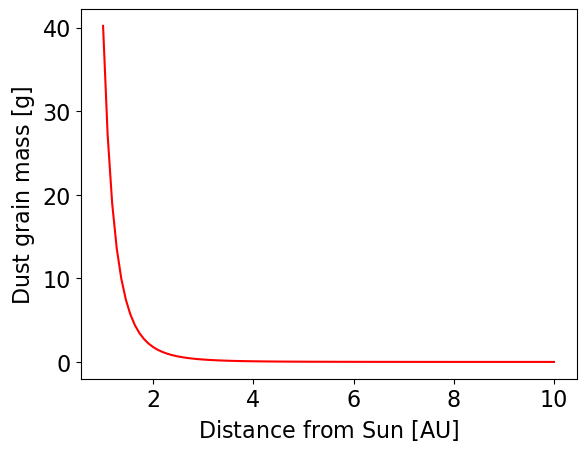

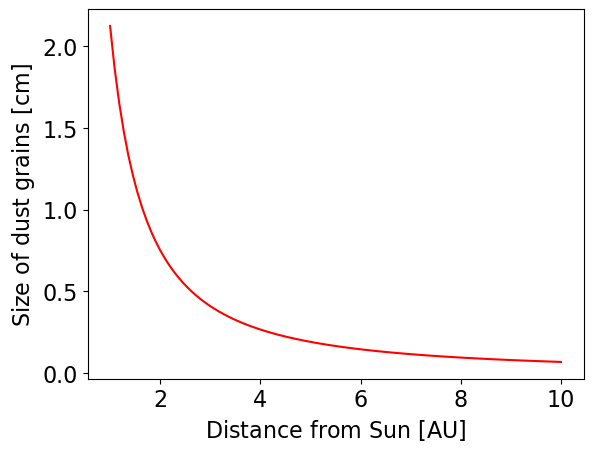

In [6]:
initial_size = 0.3*u.um
eta_nd = 100
surface_density = lambda r: (1.7E3*(r/u.AU)**(-3/2))*(u.g * u.cm**(-2))
rho_d = 1*u.g*u.cm**(-3)

def mass(r):
    return ((np.pi * (3/(4*np.pi*rho_d))**(2/3) * eta_nd**(-1) * (surface_density(r)/6))**(3)).to(u.g)

def size(r):
    """Calculate the size just assuming the density is constant (\rho_d=1 g cm^-3)"""
    m = mass(r)
    return ((3*m / (4*np.pi * rho_d))**(1/3)).to(u.cm)

rs = np.linspace(1,10,100)*u.AU
plt.plot(rs, mass(rs), color="red")
plt.xlabel(r"Distance from Sun [$\mathrm{AU}$]")
plt.ylabel(r"Dust grain mass [$\mathrm{g}$]")
plt.show()

plt.plot(rs, size(rs), color="red")
plt.xlabel(r"Distance from Sun [$\mathrm{AU}$]")
plt.ylabel(r"Size of dust grains [$\mathrm{c m}$]")
plt.show()


## 3.

We consider a location at $r=10\mathrm{AU}$ around a $1M_\odot$ star. The radial temperature scales as $T\propto r^{-1/2}$ and $\Sigma\propto r^{-1}$. The surface density at this particular radius is $\Sigma=300\mathrm{g \ cm^{-2}}$ and $T=100\mathrm{K}$.

We can start with the hydrostatic equilibrium in the vertical portion of the disk:

$$\frac{\mathrm{d}P}{\mathrm{d}z}=-\rho g_z$$
We can calcuate $g_z$ as the gravity in the $z$ axis from the central star. We also use the approximation $z\ll r$ to simplify the trigonomical functions:

$$g_z = \frac{GM}{r^2} \sin \theta = \frac{GM}{r^2} \frac{z}{r} = \frac{GMz}{r^3} 
$$ 

We also know the pressure is $P=\rho c_s^2$, with $c_s^2=\frac{kT}{\mu m_H}$. As we are assuming an isothermal vertical profile, the sound speed won't change vertically, and we can directly input that pressure equation in the hydrostatic equilibrium equation to solve for the density profile:

\begin{align*}
    \frac{\mathrm{d}P}{\mathrm{d}z} &= -\rho g_z \\
    \frac{\mathrm{d}(\rho c_s^2)}{\mathrm{d}z} &= -\rho g_z \\
    \frac{\mathrm{d}\rho}{\mathrm{d}z} &= \frac{-\rho g_z}{c_s^2} \\
    \frac{1}{\rho}\mathrm{d}\rho &= -\frac{GMz}{r^3 c_s^2} \mathrm{d}z \\
    \int \frac{1}{\rho}\mathrm{d}\rho &= -\frac{GM}{r^3 c_s^2}\int z \mathrm{d}z \\
    \ln \rho &= -\frac{GM}{2r^3 c_s^2} z^2 + C \\
    \rho &= \exp\left[-\frac{GM}{2r^3 c_s^2} z^2 + C\right] \\
    \rho &= D\exp\left[-\frac{GM}{2r^3 c_s^2} z^2\right] \\
\end{align*}

We can see that the constant $D=e^{C}$ is the density when $z=0$, so we rename it $\rho_0$.

$$\rho = \rho_0\exp\left[-\frac{GM}{2r^3 c_s^2} z^2\right]$$

We know the surface density is the density integrated over the vertical axis, so we can integrate our density function and equate it to the given value to solve for $\rho_0$:

\begin{align*}
    \Sigma &= \int_{-\infty}^\infty \rho \mathrm{d}z \\
    \Sigma &= 2\int_0^\infty \rho \mathrm{d}z \\
    \Sigma &= 2\int_0^\infty \rho_0\exp\left[-\frac{GM}{2r^3 c_s^2} z^2\right] \mathrm{d}z \\
    \Sigma &= 2\rho_0 \int_0^\infty \exp\left[-\frac{GM}{2r^3 c_s^2} z^2\right] \mathrm{d}z \\
    \Sigma &= 2\rho_0 \sqrt{\frac{\pi c_s^2 r^3}{2GM}} \\
\end{align*}

For the specified radius $r=10\mathrm{AU}$, $\Sigma=300 \mathrm{g / cm^{-2}}$, and $c_s=\sqrt{\frac{kT}{\mu m_H}}=0.586\mathrm{km/s}$ with $\mu m_H = 2.4m_H$. We can inject those values in the equation above and solve for $\rho_0$:

$$300 \mathrm{g / cm^{-2}} = 2\rho_0 \sqrt{\frac{\pi (0.586\mathrm{km/s})^2 (10\mathrm{AU})^3}{2GM_\odot}}$$
$$\rho_0 = 1.2849\times 10^{-11} \mathrm{g \ cm^{-3}}$$

The scale height $H/r$ can also be calculated:

$$\frac{H}{r} = \frac{c_s}{v_k} = \frac{c_s}{\sqrt{\frac{GM_\star}{r}}} = 6.2265\times10^{-2}$$

We can now plot the vertical profile of the mass density at $r=10\mathrm{AU}$:

c_s: 0.586458287687099 km / s
rho0: 1.2848779952376163e-11 g / cm3
v_k: 9.4187465587987 km / s
H/R: 0.062265003525256546
H: 0.6226500352525655 AU


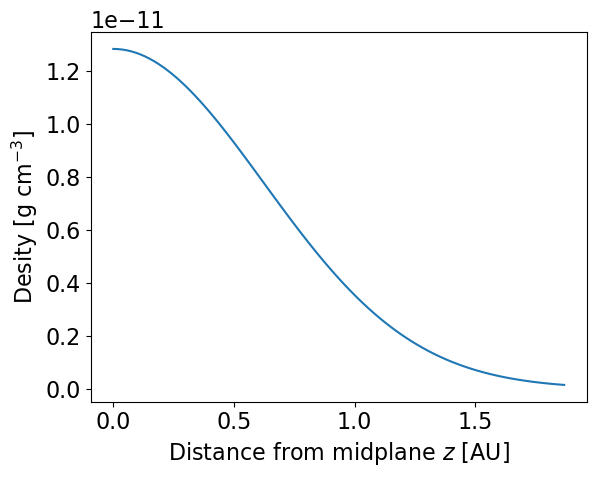

In [177]:
R = 10*u.AU
Sigma = 300*u.g*u.cm**(-2)
T = 100*u.K
mH = cst.m_p

# Calculate c_s:
c_s2 = (cst.k_B*T/(2.4*mH)).to((u.km / u.s)**2)
c_s = np.sqrt(c_s2)
print("c_s:", c_s)

# Calculate \rho_0:
rho0 = (Sigma/2/np.sqrt(np.pi * c_s2 * R**3/(2*cst.G * cst.M_sun))).to(u.g / u.cm**3)
print("rho0:", rho0)

# Calculate v_k:
v_k = lambda r: np.sqrt(cst.G*cst.M_sun/r)
# Calculate v_k at 10AU
print("v_k:",v_k(R).to(u.km/u.s))

# Calculate H/r:
H_r = lambda r: (c_s/v_k(r)).to(u.dimensionless_unscaled).to(u.m**0)
# Calculate H/r at 10AU
print("H/R:",H_r(R))
# Calculate H at 10AU:
H = H_r(R)*R
print("H:",H)

zs = np.linspace(0,3*H,100)
def rho(z):
    return (rho0*np.exp(-cst.G*cst.M_sun*z**2/(2*R**3*c_s2))).to(u.g / u.cm**3)
plt.plot(zs, rho(zs))
plt.xlabel(r"Distance from midplane $z$ [$\mathrm{AU}$]")
plt.ylabel(r"Desity [$\mathrm{g \ cm^{-3}}$]")
plt.show()

### b)
We search for the dependence of $\frac{H}{r}$ on $r$:
$$\frac{H}{r} = \frac{c_s}{\sqrt{\frac{GM_\star}{r}}}$$

$$\frac{H}{r} = \frac{\sqrt{\frac{kT}{\mu m_H}}}{\sqrt{GM_\star}} r^{-1/2}$$
And we know that the temperature is proportional to $r^{-1/2}$:
$$\frac{H}{r} \propto \frac{\sqrt{\frac{kr^{-1/2}}{\mu m_H}}}{\sqrt{GM_\star}} r^{1/2}$$
$$\frac{H}{r} \propto \frac{\sqrt{\frac{k}{\mu m_H}}}{\sqrt{GM_\star}} r^{1/4}$$
$$\frac{H}{r} \propto  r^{1/4}$$

We plot the dependence of $\frac{H}{r}$ as a function of $r$:

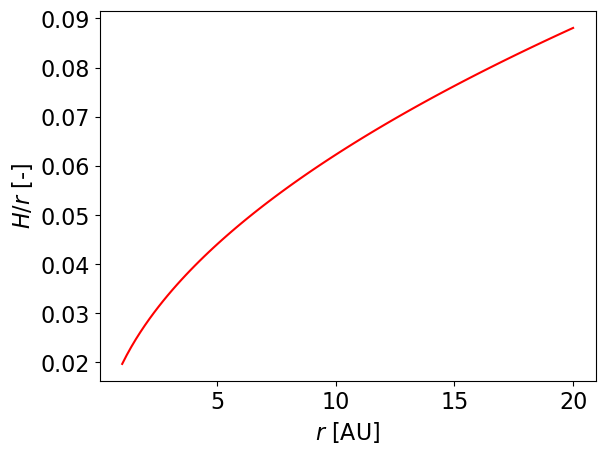

In [156]:
rs = np.linspace(1,20,100)*u.AU
plt.plot(rs, H_r(rs), color="red")
plt.xlabel(r"$r$ [$\mathrm{AU}$]")
plt.ylabel(r"$H/r$ [-]")
plt.show()

### c)

We have already calculated the Keplerian velocity $v_k$ at 10AU in the code above:

$$v_k = \sqrt{\frac{GM_\star}{r}} = 9.4187 \mathrm{km/s}$$

We can calculate the gas velocity:

$$\frac{v_\phi^2}{r} = \frac{GM_\star}{r^2}+\frac{1}{\rho}\frac{\mathrm{d}P}{\mathrm{d}r}$$

and we can approximate $\frac{1}{\rho}\frac{\mathrm{d}P}{\mathrm{d}r} \sim \frac{1}{\rho}\frac{c_s^2 \rho}{r} = \frac{c_s^2}{r}$:

$$v_\phi^2 = \frac{GM_\star}{r}+c_s^2$$
$$v_\phi^2 = v_k^2+c_s^2$$
$$v_\phi = \sqrt{v_k^2+c_s^2}$$
$$v_\phi = 9.4369\mathrm{km/s}$$

So $v_k-v_\phi = -0.0182 \mathrm{km/s}$. They are very close to each other.

In [165]:
v_phi = np.sqrt(v_k(R)**2 + c_s2).to(u.km/u.s)
print("v_phi:", v_phi)
print("v_phi-v_k:",(v_k(R)-v_phi).to((u.km/u.s)))

v_phi: 9.43698681052799 km / s
v_phi-v_k: -0.018240251729289947 km / s


### d)
The maximum radial velocity is $v_r = -\Delta v = v_k-v_\phi = -0.0182 \mathrm{km/s}$ in the radial direction. The timescale is therefore:

$$
\tau = \frac{r}{|v_r|} = 2599\mathrm{yr}
$$


In [168]:
v_r = (v_k(R)-v_phi).to((u.km/u.s))
tau = (R/np.abs(v_r)).to(u.yr)
print(tau)

2598.906272724935 yr


### e)
$$F_d = C\pi a^2 \rho_0 \Delta v c_s$$
The stopping time can be estimated using $F_d=m\frac{\Delta v}{t_s}$:
$$C\pi a^2 \rho_0 \Delta v c_s = m\frac{\Delta v}{t_s}$$
and we know $m=\frac{4\pi a^3 \rho_d}{3}$:
$$C\pi a^2 \rho_0 \Delta v c_s = \frac{4\pi a^3 \rho_d}{3}\frac{\Delta v}{t_s}$$

We can now simply isolate $a$:
$$a = \frac{3C c_s \rho_0 t_s}{\rho_d 4}$$
Substituting the values we have calculated so far (and $C=1$):
$$a = 89.76\mathrm{cm}$$

We can conclude that, to reach stopping time of $\Omega^{-1}$, we need $a=89.76\mathrm{cm}$.

In [179]:
Deltav = v_r
C = 1
Omega_k = v_k(R)/R
ts = Omega_k**(-1)
F_d = lambda a: C*np.pi*a**2*rho0*Deltav*c_s
a = (3*C*c_s*rho0*ts/(rho_d*4)).to(u.cm)

print(a)

89.76201309032236 cm
